# Experiment 02: Resize to 2.0/0.5 m

In this experiment we will study how different band configurations affect the training process and end results.

### Experiment variations:

- E01-8: All 8 MS WorldView-2 bands is used.
- E01-6: The 6 MS WorldView-2 bands that overlap the PAN band (RGB+Y+RedEdge+NIR1)
- E01-4: The 4 MS WorldView-2 bands that are also available in GeoEye-1 (MS1 array RGB+NIR1)
 - In this variation we will also validate performance on the GeoEye-1 validation set
- E01-3: Only the 3 RGB bands from WorldView-2
 - Also validated on the GeoEye-1 validation set
 
### The notebook is divided into the following main sections:
1. Imports and configuration parameters
2. Tile generation (sampling of tiles from the satellite images)
3. Tile input pipelines (`tf.dataset` objects reading tiles from disk)
4. Building of models
5. Pretraining with L1 loss
6. Build the full ESRGAN model
7. GAN-training with L1 + Percep + GAN loss
8. Inspection of results

Training history is logged with TensorBoard.

## 1. Imports and configuration parameters

In [1]:
from modules.helpers import *
from modules.tile_generator import *
from modules.matlab_metrics import *
from modules.image_utils import *
from modules.tile_input_pipeline import *
from modules.models import *
from modules.evaluation import *

from modules.logging import *
from modules.train import *

import time

# Check GPUs and enable dynamic GPU memory use:",
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            # Prevent TensorFlow from allocating all memory of all GPUs:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
### MAIN SETTINGS ###############################################################################################
EXPERIMENT_NAMES = ['e02-4', 'e02-3']

# Select experiment variation to be run in THIS notebook:
EXPERIMENT = EXPERIMENT_NAMES[0]

# Turn on and off certain time consuming processes in the notebook:
RESIZE_TO_PIXEL_SIZE = True
GENERATE_TILES = True   # This should only be done once in experiment 01. All variations will read from the same
TILE_DENSITY_MAPS = True  # Loops through all tiles and compute density maps of where tiles have been sampled
CALCULATE_STATS = True  # Loops through all tiles and calculate mean and sd. Used for scaling
PRE_BUILD = True          # Step 1 of the training process
PRETRAIN = True          # Step 1 of the training process
GAN_BUILD = False          # Step 1 of the training process
GAN_TRAIN = False         # Step 2 of the training process
PRE_EVALUATE_LAST = False
GAN_EVALUATE_LAST = False
PRE_EVALUATE_HISTORY = False
GAN_EVALUATE_HISTORY = False

# Load metadata dataframe "meta" from repository root. 
# This dataframe keeops track of images and is used and updated throughout the notebook
meta = load_meta_pickle_csv('.', 'metadata_df', from_pickle=True)
#################################################################################################################

### PATHS #######################################################################################################
DATA_PATH = 'data/toulon-laspezia'
DATA_PATH_TILES = 'data/toulon-laspezia-tiles/e02'
DATA_PATH_TILES_P = {'train': DATA_PATH_TILES + '/train', 
                     'val': DATA_PATH_TILES + '/val', 
                     'test': DATA_PATH_TILES + '/test'}
LOGS_DIR = 'logs/' # Path to tensorboard logs and model checkpoint saves
LOGS_EXP_DIR = LOGS_DIR + EXPERIMENT
#################################################################################################################

### TILE GENERATION #############################################################################################
SENSORS_GENERATE = ['WV02', 'GE01']
AREAS_GENERATE = ['La_Spezia', 'Toulon']
meta = subset_by_areas_sensor(meta, areas=AREAS_GENERATE, sensors=SENSORS_GENERATE)
print('Sensors to generate tiles from:', SENSORS_GENERATE)
print('Areas to generate tiles from:', AREAS_GENERATE)

# Count images in partitions (train/val/test):
N_IMAGES_TOTAL = count_images(meta)
N_IMAGES = {'train': count_images_in_partition(meta, 'train'), 
            'val': count_images_in_partition(meta, 'val'), 
            'test': count_images_in_partition(meta, 'test')}
assert N_IMAGES_TOTAL == sum(N_IMAGES.values())  # Verify that different ways of counting adds up
print('Number of images in partitions', N_IMAGES)
print('Total number of images:', N_IMAGES_TOTAL)

TILES_PER_M2 = {'train': 2.0, 
                'val': 2.0, 
                'test': 2.0}

# Settings for whether to send every tile generated through a sea and cloud classifier
# This is useful if images consist of a lot of sea and clouds and you want to reduce the number of tiles
# with such monotone and less meaningful content. Classifier is trained on 2500 labeled tiles of various sizes
# where only tiles COMPLETELY covered by sea and/or clouds have been labelled "cloud/sea". 
# Validation accuracy around 0.95
CLOUD_SEA_REMOVAL = True
CLOUD_SEA_WEIGHTS_PATH = 'models/cloud-sea-classifier/cloudsea-effb0-augm-bicubic-pan-0.0005--200-0.127841.h5'
# Cutoff at inference time. Tiles with (quasi)-prob higher than cutoff will be classified as cloud and or sea:
CLOUD_SEA_PRED_CUTOFF = 0.95
# Setting to keep a certain proportion of cloud/sea tiles through the filter:
CLOUD_SEA_KEEP_RATE = 0.10

### RESIZING ####################################################################################################
RESIZE_RESAMPLING_METHOD = 'nearest'  # 'nearest', 'bicubic', 'bilinear'
NEW_PIXEL_SIZE_PAN = 0.5
RESIZE_DIR = DATA_PATH + '-resized'
#################################################################################################################

### SENSORS AND AREA EXPERIMENT SELECTION #######################################################################
# Sensors used in which experiment variation
SENSORS_EXP = {'e02-4': {'train': 'WV02', 'val': ['WV02', 'GE01'], 'test': ['WV02', 'GE01']}, 
               'e02-3': {'train': 'WV02', 'val': ['WV02', 'GE01'], 'test': ['WV02', 'GE01']}}
SENSORS = SENSORS_EXP[EXPERIMENT]

# Areas used in which experiment variation
AREAS_EXP = {'e02-4': {'train': AREAS_GENERATE, 'val': AREAS_GENERATE, 'test': AREAS_GENERATE}, 
             'e02-3': {'train': AREAS_GENERATE, 'val': AREAS_GENERATE, 'test': AREAS_GENERATE}}
AREAS = AREAS_EXP[EXPERIMENT]
#################################################################################################################

### TILE DIMENSIONS #############################################################################################
# Note larger size of val and test. This is needed for sensible calculation of Ma, NIQE and PI calculation
SR_FACTOR = 4
MS_SIZE = {'train': 32, 'val': 128, 'test': 128}
PAN_SIZE = {'train': MS_SIZE['train'] * SR_FACTOR, 
            'val': MS_SIZE['val'] * SR_FACTOR, 
            'test': MS_SIZE['test'] * SR_FACTOR}
print('MS (LR) tile size:', MS_SIZE)
print('PAN (HR) tile size:', PAN_SIZE)
print('SR factor:', SR_FACTOR)
#################################################################################################################

### BAND (CHANNEL) CONFIGURATIONS ###############################################################################
# This is the essence of experiment 01
# Selection of bands is done in the tile input pipeline

# Selecting bands from the 8 bands of WV02:
WV02_FULL_BAND_CONFIG = get_sensor_bands('WV02', meta)
WV02_EXP_BAND_CONFIGS = {'e02-4': {k:v for (k,v) in WV02_FULL_BAND_CONFIG.items()  # 4 bands (BGR+NIR)
                                   if k in ['Blue', 'Green', 'Red', 'NIR']},
                         'e02-3': {k:v for (k,v) in WV02_FULL_BAND_CONFIG.items()  # 3 bands (BGR)
                                   if k in ['Blue', 'Green', 'Red']}}
MS_BANDS_WV02_CONFIG = WV02_EXP_BAND_CONFIGS[EXPERIMENT]
MS_BANDS_WV02_IDXS = list(MS_BANDS_WV02_CONFIG.values())

N_MS_BANDS = len(MS_BANDS_WV02_CONFIG.values()) # The number of MS bands in this experiment variation

# Selecting bands from the 4 bands of GE01:
GE01_FULL_BAND_CONFIG = get_sensor_bands('GE01', meta)                            
GE01_EXP_BAND_CONFIGS = {'e02-4': GE01_FULL_BAND_CONFIG,                           # 4 (all) bands (BGR+NIR)
                         'e02-3': {k:v for (k,v) in GE01_FULL_BAND_CONFIG.items()  # 3 bands (BGR)
                                   if k not in ['NIR']}}
MS_BANDS_GE01_CONFIG = GE01_EXP_BAND_CONFIGS[EXPERIMENT]
if EXPERIMENT == 'e02-4':
    MS_BANDS_GE01_IDXS = 'all'
else:
    MS_BANDS_GE01_IDXS = list(MS_BANDS_GE01_CONFIG.values())
print('MS (LR) Band Config WV02:', MS_BANDS_WV02_CONFIG)
print('MS (LR) Band Config GE01:', MS_BANDS_GE01_CONFIG)

N_PAN_BANDS = 1 # Obviously only 1 panchromatic band
#################################################################################################################

### MODEL PARAMETERS ############################################################################################
BATCH_SIZE = {'train': 16, 'val': 8, 'test': 8}
print('Batch sizes:', BATCH_SIZE)

# RRDB Generator Model parameters 
N_BLOCKS = 16 # 23 - Deeper means potential to capture more complex relationships, at the cost of training time
N_FILTERS = 64 # Baseline setting that is not tinkered with in this repository
#################################################################################################################

### PRETRAINING SETTINGS ########################################################################################
PRE_EPOCHS = 400
PRE_TRAIN_STEPS = 1000  # per epoch
PRE_VAL_STEPS = 0     # per epoch
print('Pretraining - Total steps:', PRE_EPOCHS * PRE_TRAIN_STEPS)

# Number of batches to save every epoch in TensorBoard
TRAIN_N_BATCHES_SAVE = 2
VAL_N_BATCHES_SAVE = 2

# Optimizer settings:
PRETRAIN_LOSS = 'l1'    # Official
PRETRAIN_LR = 5e-5      # Tuned and found stable for this particular experiment
#PRETRAIN_LR = 0.0002   # Official
PRETRAIN_BETA_1 = 0.9   # Official
PRETRAIN_BETA_2 = 0.999 # Official
# Note: Official implementation also uses stepwise learning rate scheduler. 
# This is avoided here as it is deemed not central to the experiment to "squeeze" out last performance and it 
# complicates comparisons between experiment variations
#################################################################################################################

### GAN TRAINING SETTINGS #######################################################################################
GAN_EPOCHS = 400
GAN_TRAIN_STEPS = 1000
GAN_VAL_STEPS = 0
# Proportion of val batches that will go through ma and niqe metric calculation
# MA_NIQE_PROPORTION = 0.04  # The calculation is very time consuming
MA_NIQE_PROPORTION = 1  # The calculation is very time consuming
print('GAN training - Total steps:', GAN_EPOCHS * GAN_TRAIN_STEPS)

# Weights for each loss in the composite loss function
G_LOSS_PIXEL_W = 0.01       # Official
G_LOSS_PERCEP_W = 1.0       # Official
G_LOSS_GENERATOR_W = 0.005  # Official

# Optimizer settings:
#GAN_G_LR = 1e-4 # Official
#GAN_D_LR = 1e-4 # Official
GAN_G_LR = 2e-5
GAN_D_LR = 2e-5
G_BETA_1, D_BETA_1 = 0.9, 0.9      # Official
G_BETA_2, D_BETA_2 = 0.999, 0.999  # Official
# Note: Official implementation also uses stepwise learning rate scheduler. 
# This is avoided here as it is deemed not central to the experiment to "squeeze" out last performance and it 
# complicates comparisons between experiment variations

# Path to the pretraining weights that is the starting point of GAN training:
#PRETRAIN_WEIGHTS_DIRS = {'e01-8': LOGS_EXP_DIR + '/models/' + 'e01-8-pre_20210116-194500/', 
#                         'e01-6': LOGS_EXP_DIR + '/models/' + 'e01-6-pre_20210122-091421/', 
#                         'e01-4': LOGS_EXP_DIR + '/models/' + 'e01-4-pre_20210119-101939/', 
#                         'e01-3': LOGS_EXP_DIR + '/models/' + 'e01-3-pre_20210124-153415/'
#                        }
#PRETRAIN_WEIGHTS_DIR = PRETRAIN_WEIGHTS_DIRS[EXPERIMENT]
#PRETRAIN_WEIGHTS_PATH = PRETRAIN_WEIGHTS_DIR + EXPERIMENT + '-pre-400.h5'
#
## Path to the gan-training weights that will be 
#GAN_WEIGHTS_DIRS = {'e01-8': LOGS_EXP_DIR + '/models/' + 'e01-8-gan_20210222-124759/', 
#                    'e01-6': LOGS_EXP_DIR + '/models/' + 'e01-6-gan_20210216-152032/', 
#                    'e01-4': LOGS_EXP_DIR + '/models/' + 'e01-4-gan_20210212-144735/', 
#                    'e01-3': LOGS_EXP_DIR + '/models/' + 'e01-3-gan_20210219-135014/'
#                   }
#GAN_WEIGHTS_DIR = GAN_WEIGHTS_DIRS[EXPERIMENT]
#GAN_WEIGHTS_PATH = GAN_WEIGHTS_DIR + EXPERIMENT + '-gan-G-399.h5'
#################################################################################################################

### MATLAB METRICS ##############################################################################################
# Calculate Ma, NIQE and Perceptual Index (PI) metrics on the validation set(s) during GAN training:
# PI was metric used in PIRM2018 competition https://github.com/roimehrez/PIRM2018
METRIC_MA = False
METRIC_NIQE = False
if METRIC_MA and METRIC_NIQE:
    METRIC_PI = True
else:
    METRIC_PI = False

# The number of pixels to be shaved off the border of the tile before calculating Ma/NIQE/PI (ignore border effects)
SHAVE_WIDTH = 4 # Official (as used in PIRM2018 evaluation)
# Ma/NIQE/PI calculation is done with official matlab repositories through MATLAB Engine API for Python
MATLAB_PATH = 'modules/matlab' # path to repositories
#################################################################################################################

### EVALUTAION ##################################################################################################
if PRE_EVALUATE_LAST or GAN_EVALUATE_LAST:
    METRIC_MA = False
    METRIC_NIQE = True
    if METRIC_MA and METRIC_NIQE:
        METRIC_PI = True
    else:
        METRIC_PI = False
        
if PRE_EVALUATE_HISTORY and GAN_EVALUATE_HISTORY:
    raise ValueError

EVAL_STEPS_PER_EPOCH = 2000
EVAL_N_EPOCHS = 400
EVAL_SENSOR = 'WV02'
EVAL_PER_IMAGE = True
    
if PRE_EVALUATE_HISTORY:
    EVAL_WEIGHTS_DIR = PRETRAIN_WEIGHTS_DIR
    EVAL_FIRST_STEP = 1
    EVAL_PREFIX = EXPERIMENT + '-pre-'
elif GAN_EVALUATE_HISTORY:
    EVAL_WEIGHTS_DIR = GAN_WEIGHTS_DIR
    EVAL_FIRST_STEP = 0
    EVAL_PREFIX = EXPERIMENT + '-gan-'
    
print('MATLAB Metrics:')
print('Ma:', METRIC_MA)
print('NIQE:', METRIC_NIQE)
print('Perceptual Index (PI):', METRIC_PI)

Sensors to generate tiles from: ['WV02', 'GE01']
Areas to generate tiles from: ['La_Spezia', 'Toulon']
Number of images in partitions {'train': 22, 'val': 19, 'test': 21}
Total number of images: 62
MS (LR) tile size: {'train': 32, 'val': 128, 'test': 128}
PAN (HR) tile size: {'train': 128, 'val': 512, 'test': 512}
SR factor: 4
MS (LR) Band Config WV02: {'Blue': 1, 'Green': 2, 'Red': 4, 'NIR': 6}
MS (LR) Band Config GE01: {'Blue': 0, 'Green': 1, 'Red': 2, 'NIR': 3}
Batch sizes: {'train': 16, 'val': 8, 'test': 8}
Pretraining - Total steps: 400000
GAN training - Total steps: 400000
MATLAB Metrics:
Ma: False
NIQE: False
Perceptual Index (PI): False


## 2. Tile generation

### 2.1 Image resizing

Function `resize_sat_img_to_new_pixel_size` available in `modules.tile_generator`. Not used in this notebook

In [3]:
if RESIZE_TO_PIXEL_SIZE:
    meta = resize_all_sat_imgs_to_new_pixel_size(meta, 
                                                 save_dir=RESIZE_DIR, 
                                                 new_pixel_size_pan=(NEW_PIXEL_SIZE_PAN, NEW_PIXEL_SIZE_PAN),
                                                 sr_factor=SR_FACTOR, resampling='nearest')

GE01_La_Spezia_2009_09_25_011651186010_0
Dimensions before resize (4, 1898, 3272) (1, 7592, 13088)
Resize by factors (height, width):
pan (0.9499663710594178, 0.9499663710594178) , ms: (0.9499663710594175, 0.9499663710594175)
Dimensions after resize (4, 1803, 3108) (1, 7212, 12433)
Saved resized versions to data/toulon-laspezia-resized/GE01_La_Spezia_2009_09_25_011651186010_0

GE01_La_Spezia_2011_01_24_011651197010_0
Dimensions before resize (4, 1994, 3275) (1, 7976, 13100)
Resize by factors (height, width):
pan (0.9493790864944458, 0.9493790864944458) , ms: (0.949379086494446, 0.949379086494446)
Dimensions after resize (4, 1893, 3109) (1, 7572, 12436)
Saved resized versions to data/toulon-laspezia-resized/GE01_La_Spezia_2011_01_24_011651197010_0

GE01_La_Spezia_2012_02_23_011651192010_0
Dimensions before resize (4, 2138, 3512) (1, 8552, 14048)
Resize by factors (height, width):
pan (0.8852646350860596, 0.8852646350860596) , ms: (0.8852646350860595, 0.8852646350860595)
Dimensions after

new pixel size 0.5 == old pixel size 0.5
-> just copied tifs to data/toulon-laspezia-resized/WV02_La_Spezia_2011_10_28_011650745010_0
WV02_La_Spezia_2012_01_10_011650582010_0
new pixel size 0.5 == old pixel size 0.5
-> just copied tifs to data/toulon-laspezia-resized/WV02_La_Spezia_2012_01_10_011650582010_0
WV02_La_Spezia_2012_05_17_011650585010_0
Dimensions before resize (8, 2010, 3301) (1, 8040, 13204)
Resize by factors (height, width):
pan (0.9417843222618104, 0.9417843222618104) , ms: (0.9417843222618105, 0.9417843222618105)
Dimensions after resize (8, 1892, 3108) (1, 7571, 12435)
Saved resized versions to data/toulon-laspezia-resized/WV02_La_Spezia_2012_05_17_011650585010_0

WV02_La_Spezia_2013_10_31_011650588010_0
Dimensions before resize (8, 1990, 3144) (1, 7959, 12576)
Resize by factors (height, width):
pan (0.951728880405426, 0.951728880405426) , ms: (0.951728880405426, 0.951728880405426)
Dimensions after resize (8, 1893, 2992) (1, 7574, 11968)
Saved resized versions to data/t

new pixel size 0.5 == old pixel size 0.5
-> just copied tifs to data/toulon-laspezia-resized/WV02_Toulon_2019_07_29_011650877010_0
WV02_Toulon_2019_08_04_011650878010_0
new pixel size 0.5 == old pixel size 0.5
-> just copied tifs to data/toulon-laspezia-resized/WV02_Toulon_2019_08_04_011650878010_0
WV02_Toulon_2019_09_11_011650876010_0
new pixel size 0.5 == old pixel size 0.5
-> just copied tifs to data/toulon-laspezia-resized/WV02_Toulon_2019_09_11_011650876010_0
WV02_Toulon_2019_10_16_011650874010_0
new pixel size 0.5 == old pixel size 0.5
-> just copied tifs to data/toulon-laspezia-resized/WV02_Toulon_2019_10_16_011650874010_0
WV02_Toulon_2019_12_15_011650875010_0
new pixel size 0.5 == old pixel size 0.5
-> just copied tifs to data/toulon-laspezia-resized/WV02_Toulon_2019_12_15_011650875010_0


### 2.2 Tile allocation

We allocate `n_tiles` to each satellite image in proportion to the area covered by the satellite image. We adjust `n_tiles` by the argument `tiles_per_m2`. If `tiles_per_m2=1.0` then `n_tiles` is set deterministically to a value so that a square meter of satellite image is expected to be covered by `1.0` tile.

In [4]:
if GENERATE_TILES:
    meta = allocate_tiles_by_expected(meta, 
                                      override_pan_pixel_size=NEW_PIXEL_SIZE_PAN,
                                      by_partition=True, 
                                      tiles_per_m2_train_val_test=(TILES_PER_M2['train'], 
                                                                   TILES_PER_M2['val'], 
                                                                   TILES_PER_M2['test']),
                                      pan_tile_size_train_val_test=(PAN_SIZE['train'], 
                                                                    PAN_SIZE['val'], 
                                                                    PAN_SIZE['test']),
                                      new_column_name='n_tiles')
else:
    # Load meta dataframe that was updated at tile generation time
    meta = load_meta_pickle_csv(DATA_PATH_TILES, 'metadata_tile_allocation', from_pickle=True)

n_tiles = {'train': count_tiles_in_partition(meta, 'train'),
           'val': count_tiles_in_partition(meta, 'val'), 
           'test':  count_tiles_in_partition(meta, 'test')}
n_tiles_total = count_tiles(meta)
assert n_tiles_total == sum(n_tiles.values())
print('Number of tiles per partition:')
print(n_tiles)
print('Total number of tiles:', n_tiles_total)

Number of tiles per partition:
{'train': 185087, 'val': 9379, 'test': 10614}
Total number of tiles: 205080


### 2.3 Tile generation to disk

In [5]:
if GENERATE_TILES:
    meta = generate_all_tiles(meta, 
                              save_dir=DATA_PATH_TILES, 
                              sr_factor=SR_FACTOR, 
                              by_partition=True,
                              ms_tile_size_train_val_test=(MS_SIZE['train'], MS_SIZE['val'], MS_SIZE['test']), 
                              cloud_sea_removal=CLOUD_SEA_REMOVAL, 
                              cloud_sea_weights_path=CLOUD_SEA_WEIGHTS_PATH, 
                              cloud_sea_pred_cutoff=CLOUD_SEA_PRED_CUTOFF,
                              cloud_sea_keep_rate=CLOUD_SEA_KEEP_RATE,
                              save_meta_to_disk=True)

Generating 185087 training, 9379 validation and 10614 test tiles:
test set - From image GE01_La_Spezia_2009_09_25_011651186010_0 - Generating 676 tiles
Shapes (4, 1803, 3108) (1, 7212, 12433)
Number of tiles discarded and resampled due to border pixels: 6
Number of tiles classified as being only clouds or sea: 194
Number of tiles kept despite being only clouds or sea: 21
Tiles actually generated to disk: 503

test set - From image GE01_La_Spezia_2011_01_24_011651197010_0 - Generating 717 tiles
Shapes (4, 1893, 3109) (1, 7572, 12436)
Number of tiles discarded and resampled due to border pixels: 0
Number of tiles classified as being only clouds or sea: 179
Number of tiles kept despite being only clouds or sea: 13
Tiles actually generated to disk: 551

val set - From image GE01_La_Spezia_2012_02_23_011651192010_0 - Generating 717 tiles
Shapes (4, 1892, 3109) (1, 7570, 12436)
Number of tiles discarded and resampled due to border pixels: 1
Number of tiles classified as being only clouds or 

Number of tiles discarded and resampled due to border pixels: 0
Number of tiles classified as being only clouds or sea: 4136
Number of tiles kept despite being only clouds or sea: 410
Tiles actually generated to disk: 7759

train set - From image WV02_La_Spezia_2012_05_17_011650585010_0 - Generating 11484 tiles
Shapes (8, 1892, 3108) (1, 7571, 12435)
Number of tiles discarded and resampled due to border pixels: 0
Number of tiles classified as being only clouds or sea: 4735
Number of tiles kept despite being only clouds or sea: 470
Tiles actually generated to disk: 7219

train set - From image WV02_La_Spezia_2013_10_31_011650588010_0 - Generating 10996 tiles
Shapes (8, 1893, 2992) (1, 7574, 11968)
Number of tiles discarded and resampled due to border pixels: 74
Number of tiles classified as being only clouds or sea: 4507
Number of tiles kept despite being only clouds or sea: 471
Tiles actually generated to disk: 6960

train set - From image WV02_La_Spezia_2013_12_08_011650589010_0 - Gen

Number of tiles discarded and resampled due to border pixels: 0
Number of tiles classified as being only clouds or sea: 82
Number of tiles kept despite being only clouds or sea: 8
Tiles actually generated to disk: 344

train set - From image WV02_Toulon_2014_04_06_011651052010_0 - Generating 6701 tiles
Shapes (8, 1458, 2356) (1, 5832, 9424)
Number of tiles discarded and resampled due to border pixels: 5
Number of tiles classified as being only clouds or sea: 2379
Number of tiles kept despite being only clouds or sea: 242
Tiles actually generated to disk: 4564

val set - From image WV02_Toulon_2015_11_16_011651049010_0 - Generating 418 tiles
Shapes (8, 1458, 2356) (1, 5832, 9424)
Number of tiles discarded and resampled due to border pixels: 0
Number of tiles classified as being only clouds or sea: 73
Number of tiles kept despite being only clouds or sea: 9
Tiles actually generated to disk: 354

train set - From image WV02_Toulon_2016_03_14_011651064010_0 - Generating 6701 tiles
Shapes (

Density map written to disk @ data/toulon-laspezia-tiles/e02/density-maps/GE01_La_Spezia_2009_09_25_011651186010_0.tif
Density map written to disk @ data/toulon-laspezia-tiles/e02/density-maps/GE01_La_Spezia_2011_01_24_011651197010_0.tif
Density map written to disk @ data/toulon-laspezia-tiles/e02/density-maps/GE01_La_Spezia_2012_02_23_011651192010_0.tif
Density map written to disk @ data/toulon-laspezia-tiles/e02/density-maps/GE01_La_Spezia_2012_05_07_011651189010_0.tif
Density map written to disk @ data/toulon-laspezia-tiles/e02/density-maps/GE01_La_Spezia_2012_05_16_011651187010_0.tif
Density map written to disk @ data/toulon-laspezia-tiles/e02/density-maps/GE01_La_Spezia_2013_07_07_011651184010_0.tif
Density map written to disk @ data/toulon-laspezia-tiles/e02/density-maps/GE01_La_Spezia_2013_07_15_011651183010_0.tif
Density map written to disk @ data/toulon-laspezia-tiles/e02/density-maps/GE01_La_Spezia_2013_07_18_011651195010_0.tif
Density map written to disk @ data/toulon-laspez

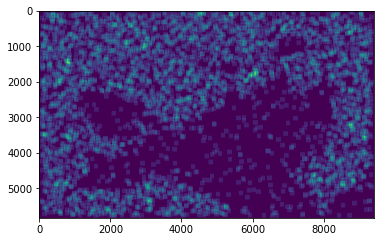

In [6]:
if TILE_DENSITY_MAPS:
    for row in meta.iterrows():
        img_uid = row[0]
        density = tile_density_map(DATA_PATH_TILES, 
                                   row[1], 
                                   pan_or_ms='pan',
                                   density_dtype='uint8',
                                   write_to_disk=True,
                                   write_dir=DATA_PATH_TILES + '/density-maps', 
                                   write_filename=img_uid)
    # Plot last density
    plt.imshow(density)

In [7]:
if CALCULATE_STATS:
    train_tiles_mean, train_tiles_sd = mean_sd_of_train_tiles(DATA_PATH_TILES, 
                                                              sample_proportion=1.0, 
                                                              write_json=True)
else:
    train_tiles_mean, train_tiles_sd = read_mean_sd_json(DATA_PATH_TILES)

Path to image tiles: data\toulon-laspezia-tiles\e02\train
Calculating mean and sd of 253322 image tiles from the population of 253322 tiles.
Calculated mean and sd of 4999 tiles
Calculated mean and sd of 9999 tiles
Calculated mean and sd of 14999 tiles
Calculated mean and sd of 19999 tiles
Calculated mean and sd of 24999 tiles
Calculated mean and sd of 29999 tiles
Calculated mean and sd of 34999 tiles
Calculated mean and sd of 39999 tiles
Calculated mean and sd of 44999 tiles
Calculated mean and sd of 49999 tiles
Calculated mean and sd of 54999 tiles
Calculated mean and sd of 59999 tiles
Calculated mean and sd of 64999 tiles
Calculated mean and sd of 69999 tiles
Calculated mean and sd of 74999 tiles
Calculated mean and sd of 79999 tiles
Calculated mean and sd of 84999 tiles
Calculated mean and sd of 89999 tiles
Calculated mean and sd of 94999 tiles
Calculated mean and sd of 99999 tiles
Calculated mean and sd of 104999 tiles
Calculated mean and sd of 109999 tiles
Calculated mean and sd 

## 3. Data input pipeline from disk

### 3.1 Training set

In [8]:
SHUFFLE_BUFFER_SIZE = {'train': n_tiles['train'],  # 100
                       'val': n_tiles['val'],  # 100
                       'test': n_tiles['test']}  # 100

train_val_test = 'train'
sensor = SENSORS[train_val_test]
ds_train = {sensor: GeotiffDataset(tiles_path=DATA_PATH_TILES_P[train_val_test], 
                                   batch_size=BATCH_SIZE[train_val_test], 
                                   ms_tile_shape=(MS_SIZE[train_val_test], MS_SIZE[train_val_test], N_MS_BANDS), 
                                   pan_tile_shape=(PAN_SIZE[train_val_test], PAN_SIZE[train_val_test], N_PAN_BANDS),
                                   sensor=sensor,
                                   band_selection=MS_BANDS_WV02_IDXS, 
                                   mean_correction=train_tiles_mean,
                                   cache_memory=True,
                                   cache_file=str(DATA_PATH_TILES + '/ds_' + EXPERIMENT + '-'
                                                    + train_val_test + '-' + sensor + '_cache'), 
                                   repeat=True, 
                                   shuffle=True, 
                                   shuffle_buffer_size=SHUFFLE_BUFFER_SIZE[train_val_test])
           }
# Getting the scaled output range from the scaler. Needed to calculate PSNR and SSIM:
scaled_range = ds_train[sensor].get_scaler_output_range(print_ranges=True)

# Returning the actual tf.data.dataset object:
ds_train[sensor] = ds_train[sensor].get_dataset()
print(ds_train.keys())

Scaler ranges:
Input (uint) min, max: 0 2047
Input (uint) range: 2048
Output (float) range 1.1985849150714039
Output (float) min, max: -0.19799966853084155 1.0
dict_keys(['WV02'])


### 3.2 Validation set

In [9]:
# Validation set can have several sensors and is organized in a dictionary
# structure: ds_val = {sensor: dataset} ... ex: ds_val = {'WV02': dataset_with_only_WV02_images}
train_val_test = 'val'
ds_val = {}
for sensor in SENSORS[train_val_test]:
    if sensor == 'WV02':
        band_indices = MS_BANDS_WV02_IDXS
    elif sensor == 'GE01':
        band_indices = MS_BANDS_GE01_IDXS
    ds_val[sensor] = GeotiffDataset(tiles_path=DATA_PATH_TILES_P[train_val_test], 
                                    batch_size=BATCH_SIZE[train_val_test], 
                                    ms_tile_shape=(MS_SIZE[train_val_test], MS_SIZE[train_val_test], N_MS_BANDS), 
                                    pan_tile_shape=(PAN_SIZE[train_val_test], PAN_SIZE[train_val_test], N_PAN_BANDS),
                                    sensor=sensor,
                                    band_selection=band_indices, 
                                    mean_correction=train_tiles_mean,
                                    cache_memory=True,
                                    cache_file=str(DATA_PATH_TILES + '/ds_' + EXPERIMENT + '-'
                                                   + train_val_test + '-' + sensor + '_cache'), 
                                    repeat=True, 
                                    shuffle=True, 
                                    shuffle_buffer_size=SHUFFLE_BUFFER_SIZE[train_val_test])
    ds_val[sensor] = ds_val[sensor].get_dataset()
print(ds_val.keys())

dict_keys(['WV02', 'GE01'])


## 4. Build preliminary models

### 4.1 Bicubic baseline model

In [10]:
bicubic = build_deterministic_sr_model(upsample_factor=SR_FACTOR,
                                       resize_method='bicubic',
                                       loss='mean_absolute_error',
                                       metrics=('PSNR', 'SSIM'),
                                       scaled_range=scaled_range)

### 4.2 ESRGAN Generator model (pretrain version)

In [11]:
if PRE_BUILD:
    pretrain_model =  build_generator(pretrain_or_gan='pretrain', 
                                      pretrain_learning_rate=PRETRAIN_LR, 
                                      pretrain_loss_l1_l2=PRETRAIN_LOSS,
                                      pretrain_beta_1=PRETRAIN_BETA_1, 
                                      pretrain_beta_2=PRETRAIN_BETA_2, 
                                      pretrain_metrics=('PSNR', 'SSIM'),
                                      scaled_range=scaled_range, 
                                      n_channels_in=N_MS_BANDS, 
                                      n_channels_out=N_PAN_BANDS, 
                                      height_width_in=None,  # None will make network image size agnostic
                                      n_filters=N_FILTERS, 
                                      n_blocks=N_BLOCKS)
    # pretrain_model.summary()

## 5. Pretraining with L1 loss

In [12]:
if PRETRAIN:
    history = pretrain_esrgan(generator=pretrain_model,
                              ds_train_dict=ds_train,
                              epochs=PRE_EPOCHS,
                              steps_per_epoch=PRE_TRAIN_STEPS,
                              initial_epoch=0,
                              validate=True,
                              ds_val_dict=ds_val,
                              val_steps=PRE_VAL_STEPS,
                              model_name=EXPERIMENT + '-pre',
                              tag=EXPERIMENT,
                              log_tensorboard=True,
                              tensorboard_logs_dir=LOGS_EXP_DIR + '/tb',
                              save_models=True,
                              models_save_dir=LOGS_EXP_DIR + '/models',
                              save_weights_only=True,
                              log_train_images=True,
                              n_train_image_batches=TRAIN_N_BATCHES_SAVE,
                              log_val_images=True,
                              n_val_image_batches=VAL_N_BATCHES_SAVE)

32 images from train-WV02 will be logged at each epoch
16 images from val-WV02 will be logged at each epoch
16 images from val-GE01 will be logged at each epoch
Callbacks: [<tensorflow.python.keras.callbacks.ModelCheckpoint object at 0x000002128C493B48>, <tensorflow.python.keras.callbacks.TensorBoard object at 0x000002128C963548>, <modules.logging.MultipleValSetsCallback object at 0x0000021286D4F348>, <modules.logging.LrHrSrImageCallback object at 0x00000211A5DFDB88>, <modules.logging.LrHrSrImageCallback object at 0x00000211A5DED508>]
Epoch 1/400
1000/1000 [==============================] - 350s 350ms/step - loss: 0.2604 - PSNR: 14.2983 - SSIM: 0.1855
Epoch 2/400
1000/1000 [==============================] - 350s 350ms/step - loss: 0.0533 - PSNR: 24.4984 - SSIM: 0.4927
Epoch 3/400
1000/1000 [==============================] - 350s 350ms/step - loss: 0.0397 - PSNR: 27.3677 - SSIM: 0.6022
Epoch 4/400
1000/1000 [==============================] - 351s 351ms/step - loss: 0.0350 - PSNR: 28.912

1000/1000 [==============================] - 349s 349ms/step - loss: 0.0152 - PSNR: 37.1029 - SSIM: 0.8581
Epoch 65/400
1000/1000 [==============================] - 349s 349ms/step - loss: 0.0153 - PSNR: 36.9635 - SSIM: 0.8577
Epoch 66/400
1000/1000 [==============================] - 349s 349ms/step - loss: 0.0146 - PSNR: 37.2568 - SSIM: 0.8642
Epoch 67/400
1000/1000 [==============================] - 349s 349ms/step - loss: 0.0143 - PSNR: 37.3617 - SSIM: 0.8635
Epoch 68/400
1000/1000 [==============================] - 359s 359ms/step - loss: 0.0147 - PSNR: 37.2798 - SSIM: 0.8629
Epoch 69/400
1000/1000 [==============================] - 349s 349ms/step - loss: 0.0153 - PSNR: 36.9600 - SSIM: 0.8583
Epoch 70/400
1000/1000 [==============================] - 349s 349ms/step - loss: 0.0149 - PSNR: 37.1462 - SSIM: 0.8614
Epoch 71/400
1000/1000 [==============================] - 349s 349ms/step - loss: 0.0150 - PSNR: 37.1660 - SSIM: 0.8609
Epoch 72/400
1000/1000 [=============================

1000/1000 [==============================] - 349s 349ms/step - loss: 0.0123 - PSNR: 38.0317 - SSIM: 0.8834
Epoch 133/400
1000/1000 [==============================] - 349s 349ms/step - loss: 0.0120 - PSNR: 38.0563 - SSIM: 0.8845
Epoch 134/400
1000/1000 [==============================] - 349s 349ms/step - loss: 0.0124 - PSNR: 38.0052 - SSIM: 0.8831
Epoch 135/400
1000/1000 [==============================] - 349s 349ms/step - loss: 0.0123 - PSNR: 38.0344 - SSIM: 0.8813
Epoch 136/400
1000/1000 [==============================] - 349s 349ms/step - loss: 0.0117 - PSNR: 38.3021 - SSIM: 0.8882
Epoch 137/400
1000/1000 [==============================] - 349s 349ms/step - loss: 0.0121 - PSNR: 38.1921 - SSIM: 0.8856
Epoch 138/400
1000/1000 [==============================] - 349s 349ms/step - loss: 0.0122 - PSNR: 37.9934 - SSIM: 0.8838
Epoch 139/400
1000/1000 [==============================] - 349s 349ms/step - loss: 0.0118 - PSNR: 38.2039 - SSIM: 0.8868
Epoch 140/400
1000/1000 [=====================

1000/1000 [==============================] - 350s 350ms/step - loss: 0.0109 - PSNR: 38.8756 - SSIM: 0.9000
Epoch 200/400
1000/1000 [==============================] - 350s 350ms/step - loss: 0.0108 - PSNR: 38.8908 - SSIM: 0.9008
Epoch 201/400
1000/1000 [==============================] - 350s 350ms/step - loss: 0.0108 - PSNR: 38.9645 - SSIM: 0.9020
Epoch 202/400
1000/1000 [==============================] - 350s 350ms/step - loss: 0.0109 - PSNR: 38.8756 - SSIM: 0.9005
Epoch 203/400
1000/1000 [==============================] - 350s 350ms/step - loss: 0.0108 - PSNR: 38.8906 - SSIM: 0.9010
Epoch 204/400
1000/1000 [==============================] - 350s 350ms/step - loss: 0.0106 - PSNR: 39.0678 - SSIM: 0.9037
Epoch 205/400
1000/1000 [==============================] - 350s 350ms/step - loss: 0.0111 - PSNR: 38.7728 - SSIM: 0.8981
Epoch 206/400
1000/1000 [==============================] - 350s 350ms/step - loss: 0.0107 - PSNR: 38.9745 - SSIM: 0.9021
Epoch 207/400
1000/1000 [=====================

1000/1000 [==============================] - 349s 349ms/step - loss: 0.0101 - PSNR: 39.4161 - SSIM: 0.9107
Epoch 267/400
1000/1000 [==============================] - 349s 349ms/step - loss: 0.0102 - PSNR: 39.2993 - SSIM: 0.9095
Epoch 268/400
1000/1000 [==============================] - 349s 349ms/step - loss: 0.0100 - PSNR: 39.5112 - SSIM: 0.9110
Epoch 269/400
1000/1000 [==============================] - 349s 349ms/step - loss: 0.0102 - PSNR: 39.3494 - SSIM: 0.9099
Epoch 270/400
1000/1000 [==============================] - 349s 349ms/step - loss: 0.0105 - PSNR: 39.1611 - SSIM: 0.9070
Epoch 271/400
1000/1000 [==============================] - 349s 349ms/step - loss: 0.0101 - PSNR: 39.4447 - SSIM: 0.9103
Epoch 272/400
1000/1000 [==============================] - 349s 349ms/step - loss: 0.0101 - PSNR: 39.5011 - SSIM: 0.9109
Epoch 273/400
1000/1000 [==============================] - 349s 349ms/step - loss: 0.0100 - PSNR: 39.4106 - SSIM: 0.9116
Epoch 274/400
1000/1000 [=====================

1000/1000 [==============================] - 349s 349ms/step - loss: 0.0097 - PSNR: 39.7722 - SSIM: 0.9162
Epoch 334/400
1000/1000 [==============================] - 349s 349ms/step - loss: 0.0097 - PSNR: 39.7818 - SSIM: 0.9177
Epoch 335/400
1000/1000 [==============================] - 349s 349ms/step - loss: 0.0097 - PSNR: 39.6697 - SSIM: 0.9164
Epoch 336/400
1000/1000 [==============================] - 349s 349ms/step - loss: 0.0098 - PSNR: 39.6247 - SSIM: 0.9169
Epoch 337/400
1000/1000 [==============================] - 349s 349ms/step - loss: 0.0099 - PSNR: 39.5734 - SSIM: 0.9161
Epoch 338/400
1000/1000 [==============================] - 349s 349ms/step - loss: 0.0096 - PSNR: 39.8264 - SSIM: 0.9177
Epoch 339/400
1000/1000 [==============================] - 349s 349ms/step - loss: 0.0097 - PSNR: 39.7586 - SSIM: 0.9169
Epoch 340/400
1000/1000 [==============================] - 349s 349ms/step - loss: 0.0096 - PSNR: 39.8472 - SSIM: 0.9181
Epoch 341/400
1000/1000 [=====================

1000/1000 [==============================] - 349s 349ms/step - loss: 0.0092 - PSNR: 40.1049 - SSIM: 0.9233


## 6. Build the full ESRGAN Model

In [13]:
if GAN_BUILD:
    gan_model = build_esrgan_model(PRETRAIN_WEIGHTS_PATH,
                                   n_channels_in=N_MS_BANDS, 
                                   n_channels_out=N_PAN_BANDS, 
                                   n_filters=N_FILTERS, 
                                   n_blocks=N_BLOCKS, 
                                   pan_shape=(PAN_SIZE['train'], PAN_SIZE['train'], N_PAN_BANDS),
                                   G_lr=GAN_G_LR, 
                                   D_lr=GAN_D_LR, 
                                   G_beta_1=G_BETA_1, 
                                   G_beta_2=G_BETA_2, 
                                   D_beta_1=D_BETA_1, 
                                   D_beta_2=D_BETA_2,
                                   G_loss_pixel_w=G_LOSS_PIXEL_W, 
                                   G_loss_pixel_l1_l2='l1',
                                   G_loss_percep_w=G_LOSS_PERCEP_W, 
                                   G_loss_percep_l1_l2='l1', 
                                   G_loss_percep_layer=54,
                                   G_loss_percep_before_act=True,
                                   G_loss_generator_w=G_LOSS_GENERATOR_W,
                                   metric_reg=False, 
                                   metric_ma=METRIC_MA, 
                                   metric_niqe=METRIC_NIQE, 
                                   ma_niqe_proportion=MA_NIQE_PROPORTION,
                                   matlab_wd_path='modules/matlab',
                                   scale_mean=train_tiles_mean, 
                                   scaled_range=scaled_range, 
                                   shave_width=SHAVE_WIDTH)

## 7. GAN training

In [14]:
if GAN_TRAIN:
    history = gan_train_esrgan(esrgan_model=gan_model,
                               ds_train_dict=ds_train,
                               epochs=GAN_EPOCHS,
                               steps_per_epoch=GAN_TRAIN_STEPS,
                               initial_epoch=0,
                               validate=True,
                               ds_val_dict=ds_val,
                               val_steps=GAN_VAL_STEPS,
                               model_name=EXPERIMENT + '-gan',
                               tag=EXPERIMENT,
                               log_tensorboard=True,
                               tensorboard_logs_dir=LOGS_EXP_DIR + '/tb',
                               save_models=True,
                               models_save_dir=LOGS_EXP_DIR + '/models',
                               save_weights_only=True,
                               log_train_images=True,
                               n_train_image_batches=TRAIN_N_BATCHES_SAVE,
                               log_val_images=True,
                               n_val_image_batches=VAL_N_BATCHES_SAVE)

## 8. Evaluation

### 8.1 Data input pipelines for final evaluation

The pipeline is modified to include the file paths of the tiles/patches so that it is possible to log performance metrics for individual files and by extension for individual satellite images.

#### 8.1.1 Validation set

In [15]:
# Validation set can have several sensors and is organized in a dictionary
# structure: ds_val = {sensor: dataset} ... ex: ds_val = {'WV02': dataset_with_only_WV02_images}
train_val_test = 'val'
ds_val = {}
for sensor in SENSORS[train_val_test]:
    if sensor == 'WV02':
        band_indices = MS_BANDS_WV02_IDXS
    elif sensor == 'GE01':
        band_indices = MS_BANDS_GE01_IDXS
    ds_val[sensor] = GeotiffDataset(tiles_path=DATA_PATH_TILES_P[train_val_test], 
                                    batch_size=BATCH_SIZE[train_val_test], 
                                    ms_tile_shape=(MS_SIZE[train_val_test], MS_SIZE[train_val_test], N_MS_BANDS), 
                                    pan_tile_shape=(PAN_SIZE[train_val_test], PAN_SIZE[train_val_test], N_PAN_BANDS),
                                    sensor=sensor,
                                    band_selection=band_indices, 
                                    mean_correction=train_tiles_mean,
                                    cache_memory=False,
                                    cache_file=str(DATA_PATH_TILES + '/ds_' + EXPERIMENT + '-'
                                                   + train_val_test + '-' + sensor + '_filepath_cache'), 
                                    repeat=False, 
                                    shuffle=False, 
                                    shuffle_buffer_size=0, #SHUFFLE_BUFFER_SIZE[train_val_test], 
                                    include_file_paths=True)
    ds_val[sensor] = ds_val[sensor].get_dataset()
print(ds_val.keys())

dict_keys(['WV02', 'GE01'])


#### 8.1.2 Test set

In [16]:
train_val_test = 'test'
ds_test = {}
for sensor in SENSORS[train_val_test]:
    if sensor == 'WV02':
        band_indices = MS_BANDS_WV02_IDXS
    elif sensor == 'GE01':
        band_indices = MS_BANDS_GE01_IDXS
    ds_test[sensor] = GeotiffDataset(tiles_path=DATA_PATH_TILES_P[train_val_test], 
                                     batch_size=BATCH_SIZE[train_val_test], 
                                     ms_tile_shape=(MS_SIZE[train_val_test], MS_SIZE[train_val_test], N_MS_BANDS), 
                                     pan_tile_shape=(PAN_SIZE[train_val_test], PAN_SIZE[train_val_test], N_PAN_BANDS),
                                     sensor=sensor,
                                     band_selection=band_indices, 
                                     mean_correction=train_tiles_mean,
                                     cache_memory=False,
                                     cache_file=str(DATA_PATH_TILES + '/ds_' + EXPERIMENT + '-'
                                                    + train_val_test + '-' + sensor + '_filepath_cache'), 
                                     repeat=False, 
                                     shuffle=False, 
                                     shuffle_buffer_size=0)
    ds_test[sensor] = ds_test[sensor].get_dataset()
print(ds_test.keys())

dict_keys(['WV02', 'GE01'])


### 8.2 Evaluate last epoch

In [17]:
val_or_test = 'val'

# Computing Ma is 100x more time consuming than anything else. It is not interesting to measure this for pretraining
if METRIC_MA:
    PRE_GAN = ['gan']
else:
    PRE_GAN = ['pre', 'gan']
    
for pre_gan in PRE_GAN:
    for sensor in SENSORS[val_or_test]:
        if sensor == 'GE01':
            band_indices = MS_BANDS_GE01_IDXS
        elif sensor == 'WV02':
            band_indices = MS_BANDS_WV02_IDXS
        if pre_gan == 'pre':
            gan_model.G.load_weights(PRETRAIN_WEIGHTS_PATH)
        else:
            gan_model.G.load_weights(GAN_WEIGHTS_PATH)

        start = time.time()
        results_df = esrgan_evaluate(model=gan_model, 
                                     dataset=ds_val[sensor], 
                                     steps='all', 
                                     per_image=True, 
                                     write_csv=True,
                                     csv_path=str(LOGS_EXP_DIR + '/csv/' + 'final_epoch-' 
                                                  + pre_gan + '-' + val_or_test + '-' + sensor + '.csv'), 
                                     verbose=1
                                    )
        end = time.time()
        print(str((end - start) / 60), 'minutes')

NameError: name 'gan_model' is not defined

### 8.3 Evaluate every kth epoch

### 8.4 Comparison plots